## Run this cell

In [2]:
import csv
import pandas as pd
import torch
import pickle
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, BertModel

device = torch.device('cuda:3')
tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased')
bert = BertModel.from_pretrained('KB/bert-base-swedish-cased')



Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Preprocessing (no need to run again)

In [13]:
df = pd.read_csv("speeches_as_csv_full.csv")          #all speeches
party_values = df.Party.unique()
print("all party values: {}".format(party_values))
print("number of speeches: {}".format(len(df)))

all party values: [nan 'm' 's' 'kds' 'fp' 'c' 'v' '-' 'nyd' 'mp' 'kd' 'FP' 'C' 'M' 'S' 'MP'
 'SD' 'V' 'KD' 'TALMANNEN' 'TREDJE VICE TALMANNEN' 'ANDRE VICE TALMANNEN'
 'FÖRSTE VICE TALMANNEN' 'Andre vice talmannen' 'ÅLDERSPRESIDENTEN' 'L'
 'HANS MAJESTÄT KONUNGEN' 'TJÄNSTGÖRANDE ÅLDERSPRESIDENTEN']
number of speeches: 336139


In [14]:
#remove speeches with no party label
df = df.dropna()

party_values = df.Party.unique()
print("all party values: {}".format(party_values))
print("number of speeches: {}".format(len(df)))

all party values: ['m' 's' 'kds' 'fp' 'c' 'v' '-' 'nyd' 'mp' 'kd' 'FP' 'C' 'M' 'S' 'MP' 'SD'
 'V' 'KD' 'TALMANNEN' 'TREDJE VICE TALMANNEN' 'ANDRE VICE TALMANNEN'
 'FÖRSTE VICE TALMANNEN' 'Andre vice talmannen' 'ÅLDERSPRESIDENTEN' 'L'
 'HANS MAJESTÄT KONUNGEN' 'TJÄNSTGÖRANDE ÅLDERSPRESIDENTEN']
number of speeches: 333952


In [15]:
#kds = kristdemokratiska samlingspartiet = kd
df = df.replace("FP", "fp")
df = df.replace("kds", "kd")
df = df.replace("SD", "sd")
df = df.replace("KD", "kd")
df = df.replace("C", "c")
df = df.replace("M", "m")
df = df.replace("S", "s")
df = df.replace("V", "v")
df = df.replace("MP", "mp") 
df = df.replace("L", "fp")            #folkpartiet changed name to liberalerna
party_values = df.Party.unique()
print("all party values: {}".format(party_values))
print("number of speeches: {}".format(len(df)))

all party values: ['m' 's' 'kd' 'fp' 'c' 'v' '-' 'nyd' 'mp' 'sd' 'TALMANNEN'
 'TREDJE VICE TALMANNEN' 'ANDRE VICE TALMANNEN' 'FÖRSTE VICE TALMANNEN'
 'Andre vice talmannen' 'ÅLDERSPRESIDENTEN' 'HANS MAJESTÄT KONUNGEN'
 'TJÄNSTGÖRANDE ÅLDERSPRESIDENTEN']
number of speeches: 333952


In [16]:

#non-party related rows to remove from df
remove_indexes = ['-','TALMANNEN',
 'TREDJE VICE TALMANNEN', 'ANDRE VICE TALMANNEN', 'FÖRSTE VICE TALMANNEN',
 'Andre vice talmannen', 'ÅLDERSPRESIDENTEN', 'HANS MAJESTÄT KONUNGEN',
 'TJÄNSTGÖRANDE ÅLDERSPRESIDENTEN']

for item in remove_indexes:
    toremove = df[df['Party'] == '{}'.format(item)].index
    df.drop(toremove, inplace=True)

party_values = df.Party.unique()
print("all party values: {}".format(party_values))
print("number of speeches: {}".format(len(df)))

all party values: ['m' 's' 'kd' 'fp' 'c' 'v' 'nyd' 'mp' 'sd']
number of speeches: 332928


In [17]:
#very unbalanced classes
print(df["Party"].value_counts())

s      107247
m       64593
v       31474
fp      30845
c       29736
mp      29710
kd      27267
sd      10981
nyd      1075
Name: Party, dtype: int64


In [18]:
#drop the nyd class because its too small
toremove = df[df['Party'] == 'nyd'].index
df.drop(toremove , inplace=True)

party_values = df.Party.unique()
print("all party values: {}".format(party_values))
print("number of speeches: {}".format(len(df)))

all party values: ['m' 's' 'kd' 'fp' 'c' 'v' 'mp' 'sd']
number of speeches: 331853


In [19]:
print(df["Party"].value_counts())
print(len(df['Speech'].unique()))

s     107247
m      64593
v      31474
fp     30845
c      29736
mp     29710
kd     27267
sd     10981
Name: Party, dtype: int64
331829


In [9]:
#data for speeches between 2010-2021
after_2010 = df[df['Date'].astype(str).str.startswith('201', '202')]
print(after_2010["Party"].value_counts())
print(len(after_2010['Speech'].unique()))

s     35036
m     27032
mp    12494
v     10612
c     10086
fp     9334
sd     8495
kd     8267
Name: Party, dtype: int64
121353


In [10]:
after_2010.to_csv("speeches_as_csv_2010.csv")

In [11]:
#run from here

#after_2010 = pd.read_csv("speeches_as_csv_2010.csv")
after_2010[1000:1020]

,Unnamed: 0,Party,Speech,Date
189541,189541,fp,Fru talman! Luciano Astudillo beskriver de ol...,2010-04-30 00:00:00
189542,189542,s,Fru talman! Först har jag några reflexioner k...,2010-04-30 00:00:00
189543,189543,fp,Fru talman! Tillbaka till frågan om lots: Det...,2010-04-30 00:00:00
189544,189544,s,Fru talman! Jag tror inte att det tjänar syft...,2010-04-30 00:00:00
189545,189545,fp,Fru talman! Jag håller med Luciano Astudillo ...,2010-04-30 00:00:00
189546,189546,s,Fru talman! Klimatkrisen accelererar. De sena...,2010-04-30 00:00:00
189547,189547,fp,"Fru talman! Det är riktigt, som Anders Ygeman...",2010-04-30 00:00:00
189548,189548,m,Fru talman! Jag är glad att vi har denna disk...,2010-04-30 00:00:00
189549,189549,s,Fru talman! Låt mig först göra en reflexion ö...,2010-04-30 00:00:00
189550,189550,fp,Fru talman! Anders Ygeman är uppenbart besvär...,2010-04-30 00:00:00


In [20]:

#takes number, dataframe, returns new dataframe with more even classes (length of minimum class + number)
def new_dataframe(number, dataframe):
    
    
    #groups dataframes based on party, 
    grouped_parties = []
    for party, df_party in dataframe.groupby('Party'):
        grouped_parties.append(df_party)
    
    #max number of instances of each party
    maxlength = min([len(x) for x in grouped_parties]) + number

    #new dataframe gets max number of parties 
    #adjusted according to the smallest occuring class to even distribution
    new_df = pd.DataFrame()
    for item in grouped_parties:
        item = item[:maxlength]

        new_df = new_df.append(item)

    #shuffles the data
    new_df = shuffle(new_df)
    
    return new_df


new_df = new_dataframe(10000, df)           
#new_df = new_dataframe(3000, after_2010)

new_df[500:520]
print(new_df["Party"].value_counts())

kd    20981
fp    20981
c     20981
mp    20981
v     20981
s     20981
m     20981
sd    10981
Name: Party, dtype: int64


In [84]:
new_df[:5]

,Unnamed: 0,Party,Speech,Date
19481,19481,s,Fru talman! Med anledning av det som Stig Sand...,1995-02-09 00:00:00
251342,251342,sd,<p>Herr talman! Jag hör ju att regeringen och ...,2015-06-15 00:00:00
223681,223681,sd,Herr talman! Anders Andersson står och talar ...,2013-05-22 00:00:00
43490,43490,mp,Fru talman! Jag hade svårt att hålla mig från ...,1997-02-26 00:00:00
85268,85268,m,"Fru talman! Tack för svaret, finansministern! ...",2001-03-16 00:00:00


In [85]:
#change party names to values
party_values = new_df.Party.unique()

counter = 0
party_dict = {}
for item in party_values:
    party_dict[item] = counter
    counter += 1


print(party_dict)
new_df = new_df.replace({"Party": party_dict})
new_df[:5]

{'s': 0, 'sd': 1, 'mp': 2, 'm': 3, 'c': 4, 'fp': 5, 'kd': 6, 'v': 7}


,Unnamed: 0,Party,Speech,Date
19481,19481,0,Fru talman! Med anledning av det som Stig Sand...,1995-02-09 00:00:00
251342,251342,1,<p>Herr talman! Jag hör ju att regeringen och ...,2015-06-15 00:00:00
223681,223681,1,Herr talman! Anders Andersson står och talar ...,2013-05-22 00:00:00
43490,43490,2,Fru talman! Jag hade svårt att hålla mig från ...,1997-02-26 00:00:00
85268,85268,3,"Fru talman! Tack för svaret, finansministern! ...",2001-03-16 00:00:00


In [86]:


#turns each column in the dataframe into a list
speeches = new_df.Speech.tolist()
parties = new_df.Party.tolist()
dates = new_df.Date.tolist()


#stratify takes even amount of parties in train/test, so there is no unbalance between classes in train/test
train_data, test_data, label_train, label_test = train_test_split(speeches, parties, test_size=0.2, shuffle=True, stratify=parties)




In [87]:

#encodes all the data to format suitable for bert, returns list of that data

def encoder(data):
    list_of_data = []
    for text in data:
        encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,                 #start and stop token for sequences
        truncation = True,                       #truncated
        max_length=512,                          #maxlength is maximum allowable length, 512
        return_token_type_ids=False,             
        padding="max_length",                    #pad to max length
        return_attention_mask=True,              #attention only on non padded
        return_tensors='pt',                     #pytorch tensors
        ).to(device)
        list_of_data.append(encoding)           
    
    return list_of_data



train_data = encoder(train_data)
test_data = encoder(test_data)



In [88]:
train_data[5]

{'input_ids': tensor([[    2,  7172, 26201,   421,   361, 17274,    43,   654,   408,  7323,
          1081,     7,   160,    54, 11742,   246,    48,  3737,    48,  1254,
          8289,    36,   108,  5868, 18556,     7,  1362,   217,  4060,  1797,
            82,  1696,  2980,  3498,    31,    97,  1924,  1974,    19,  1686,
            48,    82,   686,  1245, 11777,   195,   100,  2971,     6,     7,
           160,    54,  1061,  1344,    67, 12201, 21963,   620,   127,   108,
          1276, 39242,   603,   945,  1864, 12948, 28404,     7, 39249,   198,
           894,    68, 12205,   108,   217,    59,  1756,   100, 20734,    65,
            97,     7,   361,   108,  9359,   118, 14869,   146,  8855,    19,
            36,   327,   724,   198,    48, 10792, 11819,    54, 11128,    36,
          1109, 28152,     7,   160,    54,  1413,   351,  7683,    43,    97,
         13002,    67,   186,   346, 12952,     7,   160,  3292,   522,   100,
            97,   561,   549,   535,  

In [89]:
test_data[0]

{'input_ids': tensor([[    2,  7172, 26201,   421,   361,   178,  1947,    66,   100,    48,
            82,    54,  1500,    48,  6269,    59,  4094,     7,   361,   108,
           382,  1523,   680,    19,    67,   217,   178,  2785, 18007, 46128,
            19,  1413,  5194,    36,   408,  8024,    18,  1465,    71,    52,
           743,   612,  8964,  8111,   512,   358, 29668, 49792,     7,   361,
           178,   127,  1765,  3253,    48,   198,   512,  4836,   358, 24744,
            33,   100,   137,  8538, 11178,    67,   423, 23048,    43,   440,
         23432,    52,   102,     7,   135,  2568,   398,   217,  1616,   230,
            82,   945,   102,     8,     7,    26,     7, 25916,   711,    52,
         49547,  6782,   185,    19,    67,   178,   358,   137, 28960, 15825,
          6974, 31281, 49796,    52,  2066,    43,  3534,    19,    48,    82,
         13560,   945,   871,  2260,    43,   559,    67,    43,   413,   664,
          2087,     7,   335,   512, 3

In [90]:
#create lists of labels and data for both train and test

train_list = []
for i in range(len(label_train)):
    to_append = label_train[i], train_data[i]
    train_list.append(to_append)

test_list = []
for i in range(len(label_test)):
    to_append = label_test[i], test_data[i]
    test_list.append(to_append)


with open('test_data', 'wb') as f:
    pickle.dump(test_list, f)

with open('train_data', 'wb') as f:
    pickle.dump(train_list, f)

# Run from here

In [43]:



def data_loader(trainingfile, testingfile, dataframe):
    
    with open(trainingfile, 'rb') as f:
        train_data = pickle.load(f)

    with open(testingfile, 'rb') as f:
        test_data = pickle.load(f)
    
    df = pd.read_csv(dataframe)       #only speeches from 2010
    
    return train_data, test_data, df


#train_list, test_list, df = data_loader("train_data", "test_data", "speeches_as_csv_cleaned.csv")                #all speeches
train_list, test_list, df = data_loader("train_data_2010", "test_data_2010", "speeches_as_csv_2010.csv")       #speeches after 2010


party_values = df.Party.unique()
counter = 0
party_dict = {}
for item in party_values:
    party_dict[item] = counter
    counter += 1
        
        
        

In [44]:

#dataloaders for shuffling and batching

train = DataLoader(train_list, shuffle=True, batch_size=16)
test = DataLoader(test_list, shuffle=True, batch_size=16)

device = torch.device('cuda:2')


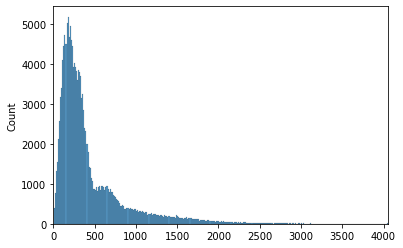

In [40]:
#plotting token counts in text

import seaborn as sns
import matplotlib.pyplot as plt

token_counts = []
for _, row in df.iterrows():
    token_count = len(tokenizer.encode(
    row["Speech"],
    max_length=4056,
    truncation=True
  ))
    token_counts.append(token_count)

sns.histplot(token_counts)
plt.xlim([0, 4056]);

In [29]:
i1, l1 = next(iter(train))
print(i1.shape)                           #labels for each item in batch
print(l1["attention_mask"].shape)         #attention mask, ie what to care about
print(l1["input_ids"].shape)              #input ids, ie translated numbers

torch.Size([16])
torch.Size([16, 1, 512])
torch.Size([16, 1, 512])


# Model

In [17]:
#freeze parameters, only fine tuning
for param in bert.parameters(): 
    param.requires_grad = False

In [18]:
import torch.nn as nn

class BERT(nn.Module):
    def __init__(self, num_parties, bert):
        super(BERT, self).__init__()   
        self.bert = bert.to(device)
        self.relu =  nn.ReLU()
        
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(256, num_parties)
        self.sigmoid = nn.Sigmoid()          

    def forward(self, input_ids, attention_mask):
        x, _ = self.bert(input_ids, attention_mask, return_dict=False) 
        
        #all sentences, first token, all hidden state outputs
        x = x[:,0,:]    #prediction on the cls token
        
        
        x = self.fc1(x)
        
        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc2(x)

        x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc3(x)

        x = self.sigmoid(x)
        
        
        return x



## Training

In [ ]:


#had problem with overfitting, but seems to be fine after added dropout, small dropout, a large dropout didnt work well
#also added relu


model = BERT(num_parties=len(party_values), bert=bert)     #input values are number of parties and itself
loss = nn.BCELoss()                                        #binary cross entropy loss between target and value
optimizer = optim.Adam(model.parameters(), lr=0.001) 
model.to(device)
total_loss = 0
epochs = 5

for i in range(epochs):

        
    for param in bert.parameters(): 
            param.requires_grad = False
    
    total_loss = 0
    for i, batch in enumerate(train):
        
        label = batch[0]
        
        a_label = label[0]

        attn = batch[1]["attention_mask"].squeeze(1)       #was in wrong format (8, 1, 512) => should be (8, 512)?
        inp = batch[1]["input_ids"].squeeze(1)             #was in wrong format (8, 1, 512) => should be (8, 512)?


        label = label.to(device)
        
        attn = attn.to(device)
        inp = inp.to(device)
        
        #turn to one hot representation to make it fit the loss function
        one_hot_label = torch.nn.functional.one_hot(label, num_classes=len(party_values))
        one_hot_label = one_hot_label.float()
        
        
        out = model(input_ids = inp, attention_mask = attn)
        
        
        loss_function = loss(out, one_hot_label).to(device)
        total_loss += loss_function.item()
        
        # compute gradients
        loss_function.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        if (i + 1) % 100 == 0:
            print("loss is now {}".format(total_loss / i + 1))           
            #torch.save(model.state_dict(), "model_bert_full")    #save model each 100th step




    print("epoch is done")

    
    
    
#have to redo old model, overwrote it wih model_bert_2010
    

loss is now 1.3853179138116163
loss is now 1.361219477114366
loss is now 1.351263716268699
loss is now 1.3456875716235703
loss is now 1.3418044345770666
loss is now 1.3383281504819309
loss is now 1.3357962967670698
loss is now 1.3342102166260585
loss is now 1.3325490292339888
loss is now 1.3313135540670342
loss is now 1.3302335293592378
loss is now 1.3293649537350558
loss is now 1.3277817212268883
loss is now 1.3268472523221466
loss is now 1.3260988539520941
loss is now 1.3250659122792836
loss is now 1.3244560384325872
loss is now 1.3233873009963324
loss is now 1.3228579199725292
loss is now 1.3223167713610395
loss is now 1.321718460239076
loss is now 1.3209870341299554
loss is now 1.3204247726985505
loss is now 1.3200388418082745
loss is now 1.319504023492694
loss is now 1.3190615281101463
loss is now 1.318613521884485
loss is now 1.318104783177546
loss is now 1.317569199359676
loss is now 1.3169306902666416
loss is now 1.3165246524871184
loss is now 1.316200834376695
loss is now 1.31

# Testing

In [46]:

#confusion matrix
def conf_mat(true, pred):

    A = [tuple(x) for x in true]
    B = [tuple(x) for x in pred]

    X = pd.Series(A, name='Actual')
    Y = pd.Series(B, name='Predicted')


    df_confusion = pd.crosstab(X, Y)

    return df_confusion


#testing
def testing(modelname, testing_data):

    model = BERT(num_parties=len(party_values), bert=bert)
    model.load_state_dict(torch.load(modelname)) #modelname
    model = model.to(device)

    model.eval()

    total_count = 0
    correct_count = 0

    y_true = []
    y_pred = []
    

    for i, batch in enumerate(testing_data):
        
        
        if modelname == "model_bert_2010":
            _, batch = batch                                   #test data for 2010 have extra list, uncomment for testing

        label = batch[0]
        attn = batch[1]["attention_mask"].squeeze(1)       
        inp = batch[1]["input_ids"].squeeze(1)             
        label = label.to(device)
        attn = attn.to(device)
        inp = inp.to(device)


        #do argmax with softmax
        with torch.no_grad(): 


            out = model(input_ids = inp, attention_mask = attn)

            softmax = nn.Softmax(dim=1)

            prediction = torch.argmax(out, dim=1)

            if (i + 1) % 50 == 0:
                print("50 more done, total done {}".format(i + 1), end="\r",)


            predictions = [[k for k,v in party_dict.items() if v == x] for x in label]
            correct = [[k for k,v in party_dict.items() if v == x] for x in prediction]
            
            
            for j in range(len(predictions)):
                y_pred.append(predictions[j])
                y_true.append(correct[j])

                if predictions[j] == correct[j]:

                    correct_count += 1
                    total_count += 1
                else:
                    total_count += 1
                    
                    
    conf_full = conf_mat(y_true, y_pred)
    return total_count, correct_count, y_true, y_pred, conf_full
    
    

#all data tested
#tot, cor, y_true, y_pred, confmat = testing("model_bert_full", test)

#2010-2020 data
tot, cor, y_true, y_pred, confmat = testing("model_bert_2010", test) #

print("total: {}, correct: {}, accuracy: {:.2f}".format(tot, cor, ((cor/tot) * 100)))
confmat
        


total: 16119, correct: 8387, accuracy: 52.03


Predicted,"(c,)","(fp,)","(kd,)","(m,)","(mp,)","(s,)","(sd,)","(v,)"
Actual,,,,,,,,
"(c,)",555,28,119,59,30,61,69,86
"(fp,)",108,1414,146,211,246,77,285,106
"(kd,)",103,32,705,108,59,20,58,97
"(m,)",227,306,276,1499,108,88,117,274
"(mp,)",202,221,322,79,1425,160,389,189
"(s,)",171,38,188,45,153,1106,205,208
"(sd,)",92,100,89,31,123,94,876,100
"(v,)",196,114,172,221,109,93,124,807
